In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline              
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') #ignore deprecation warnings

# Linear Regression Objective:

## To predict the bike rental duration if details such as rideable type, member type, distance covered and the location (start (lats, longs) and end (lats, longs)) are given.

In [119]:
#importing data
dataset = pd.read_csv('Combined_df_teg.csv')
dataset = dataset.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)
dataset['Member.type'] = dataset['Member.type'].str.lower()

In [120]:
# Cluster data

from statistics import mode
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score
from math import radians

dataset['start_lat'] = dataset['start_lat'].apply(radians)
dataset['start_lng'] = dataset['start_lng'].apply(radians)
dataset['end_lat'] = dataset['end_lat'].apply(radians)
dataset['end_lng'] = dataset['end_lng'].apply(radians)

X = dataset[['start_lat', 'start_lng', 'end_lat', 'end_lng']].values
y = dataset['Duration'].values

bestK = KMeans(n_clusters=3, init='k-means++', random_state=42)
labels4 = bestK.fit_predict(X)
dataset['kmeans_labels'] = labels4

In [121]:
dataset.head()

,Duration,Start.date,End.date,Start.station.number,Start.station,End.station.number,End.station,rideable_type,Member.type,start_lat,start_lng,end_lat,end_lng,distance_miles,kmeans_labels
0,27.583333,2016-09-15 05:38:08,2016-09-15 06:05:43,31000.0,Eads St & 15th St S,31205.0,21st & I St NW,classic_bike,member,0.678218,-1.344834,0.678945,-1.344714,2.902853,1
1,6.400000,2016-02-02 20:08:34,2016-02-02 20:14:58,31000.0,Eads St & 15th St S,31005.0,Pentagon City Metro / 12th & S Hayes St,classic_bike,member,0.678218,-1.344834,0.678275,-1.344950,0.422571,1
2,112.516667,2016-01-16 11:52:15,2016-01-16 13:44:46,31000.0,Eads St & 15th St S,31000.0,Eads St & 15th St S,classic_bike,casual,0.678218,-1.344834,0.678217,-1.344833,0.005750,1
3,22.533333,2016-04-24 07:32:58,2016-04-24 07:55:30,31000.0,Eads St & 15th St S,31247.0,Jefferson Dr & 14th St SW,classic_bike,casual,0.678218,-1.344834,0.678733,-1.344469,2.327890,1
4,17.316667,2016-05-16 09:40:43,2016-05-16 09:58:03,31000.0,Eads St & 15th St S,31088.0,Mount Vernon Ave & Kennedy St,classic_bike,casual,0.678218,-1.344834,0.677765,-1.344948,1.827691,1


In [122]:
# Drop redundant columns
dataset.drop(columns=['Start.date', 'End.date', 'Start.station.number', 'Start.station', 'End.station.number', 'End.station', 'start_lat', 'start_lng', 'end_lat', 'end_lng'], inplace=True)

In [124]:
dataset.head()

,Duration,rideable_type,Member.type,distance_miles,kmeans_labels
0,27.583333,classic_bike,member,2.902853,1
1,6.400000,classic_bike,member,0.422571,1
2,112.516667,classic_bike,casual,0.005750,1
3,22.533333,classic_bike,casual,2.327890,1
4,17.316667,classic_bike,casual,1.827691,1


In [54]:
# using pd.to_datetime do feature engineering
# dataset['Start.date'] = pd.to_datetime(dataset['Start.date'])
# dataset['End.date'] = pd.to_datetime(dataset['End.date'])

# dataset['start_year'] = dataset['Start.date'].dt.year
# dataset['start_month'] = dataset['Start.date'].dt.month
# dataset['start_day'] = dataset['Start.date'].dt.day

# dataset['end_year'] = dataset['End.date'].dt.year
# dataset['end_month'] = dataset['End.date'].dt.month
# dataset['end_day'] = dataset['End.date'].dt.day

In [125]:
data_model = dataset.sample(frac=0.01).reset_index(drop=True)

In [126]:
data_model.shape

(21072, 5)

In [127]:
X = data_model.drop(columns=['Duration'])
y = data_model['Duration']

In [107]:
# from matplotlib import rcParams
# corrMatt = X.corr()
# mask = np.array(corrMatt)
# # Turning the lower-triangle of the array to false
# mask[np.tril_indices_from(mask)] = False
# rcParams['figure.figsize'] = 8,8
# rcParams['figure.dpi'] = 100
# fig,ax = plt.subplots()
# sns.heatmap(corrMatt, 
#             mask=mask,
#             vmax=.8, 
#             square=True,
#             annot=True, fmt='.2f',
#             cmap=sns.light_palette("seagreen", as_cmap=True)
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# )
# plt.title('Correlation plot of variables')
# plt.rc('font',size=10)

In [128]:
X.head()

,rideable_type,Member.type,distance_miles,kmeans_labels
0,classic_bike,member,0.482018,1
1,classic_bike,member,0.468603,1
2,classic_bike,casual,1.791614,1
3,classic_bike,member,0.614417,0
4,docked_bike,member,0.498364,1


In [130]:
# kmeans_labels column must be treated as a categorical variable

X['kmeans_labels'] = X['kmeans_labels'].apply(str)

In [131]:
# Encoding categorical data
from sklearn.preprocessing import OneHotEncoder

X_cols = ['rideable_type', 'Member.type', 'kmeans_labels']
X_cols_encoded = []
for col in X_cols:
  X_cols_encoded += [f"{col[0]}_{x}" for x in list(X[col].unique())]

X_cols_encoded

['r_classic_bike',
 'r_docked_bike',
 'r_electric_bike',
 'M_member',
 'M_casual',
 'k_1',
 'k_0']

In [132]:
oh_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cols = oh_encoder.fit_transform(X[X_cols])
X_enc = pd.DataFrame(encoded_cols, columns=X_cols_encoded)
X_oh = X.join(X_enc)
X_oh

,rideable_type,Member.type,distance_miles,kmeans_labels,r_classic_bike,r_docked_bike,r_electric_bike,M_member,M_casual,k_1,k_0
0,classic_bike,member,0.482018,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,classic_bike,member,0.468603,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,classic_bike,casual,1.791614,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,classic_bike,member,0.614417,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,docked_bike,member,0.498364,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
21067,docked_bike,casual,0.514710,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0
21068,classic_bike,member,0.474970,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0
21069,classic_bike,member,1.348505,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0
21070,classic_bike,member,2.760933,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [133]:
X_oh.drop(columns=['rideable_type','Member.type','kmeans_labels'], inplace = True)

In [134]:
X_oh.head()

,distance_miles,r_classic_bike,r_docked_bike,r_electric_bike,M_member,M_casual,k_1,k_0
0,0.482018,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.468603,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.791614,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.614417,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.498364,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [135]:
y.head()

0     3.566667
1    26.700000
2    78.250000
3     4.500000
4     6.400000
Name: Duration, dtype: float64

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size = 0.2, random_state = 2190)

In [137]:
# evaluate a linear regression model on the dataset
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# define model
model = LinearRegression()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
# valid params: ['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'].
grid['fit_intercept'] = np.arange(0, 1, 0.01)   # check different hyperparameters for linear regression
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -13.128
Config: {'fit_intercept': 0.0}


In [138]:
# make a prediction
y_pred = results.predict(X_test)
# summarize prediction
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)),1))

[[1.90e+01 1.53e+01]
 [2.66e+01 1.40e+01]
 [1.93e+01 2.45e+01]
 ...
 [6.87e+00 6.33e-01]
 [3.39e+01 9.50e+02]
 [3.87e+01 4.47e+01]]


In [140]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))

Mean absolute error = 14.8
Mean squared error = 25133.51
Median absolute error = 4.97
Explain variance score = 0.01
R2 score = 0.01


Text(0, 0.5, 'y_pred')

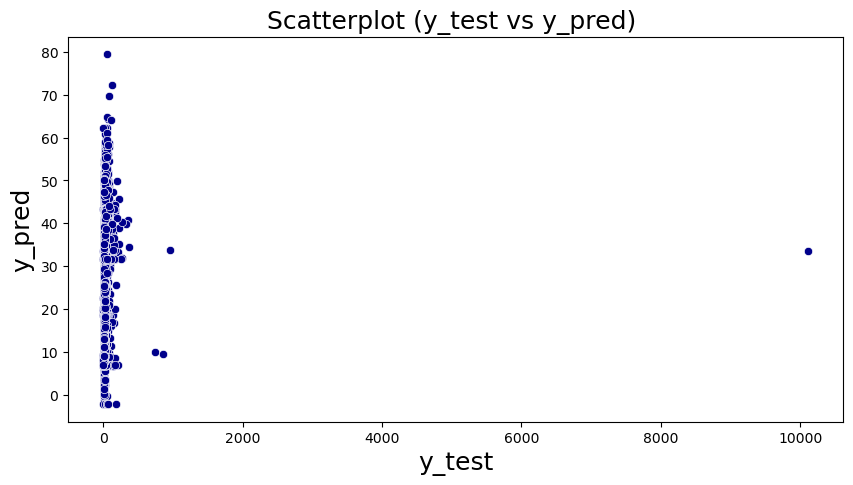

In [141]:
plt.figure(figsize=(10,5))
FS = 18
ax = sns.scatterplot(x=y_test, y=y_pred, color='DarkBlue')
# set title
plt.title('Scatterplot (y_test vs y_pred) ', fontsize = FS)
# set x-axis label
plt.xlabel('y_test', fontsize = FS)
# set y-axis label
plt.ylabel('y_pred', fontsize = FS)